## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import altair as alt

from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import roc_curve


## Read in the data

In [2]:
train_df = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")

In [3]:
train_df.shape

(20758, 18)

## EDA

In [4]:
data_description = {
    "Gender": "Gender",
    "Age": "Age",
    "Height": "Height(m)",
    "Weight": "Weight(kg)",
    "family_history_with_overweight": "Family history with overweight",
    "FAVC": "Frequent consumption of high caloric food",
    "FCVC": "Frequency of consumption of vegetables",
    "NCP": "Number of main meals",
    "CAEC": "Consumption of food between meals",
    "SMOKE": "Smoke or not",
    "CH2O": "Consumption of water daily",
    "SCC": "Calories consumption monitoring",
    "FAF": "Physical activity frequency",
    "TUE": "Time using technology devices",
    "CALC": "Consumption of alcohol",
    "MTRANS": "Transportation used",
    "Obeyesdad": "Obesity level deducted"
}

In [5]:
train_df.head(3)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight


In [6]:
train_df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [8]:
# Summary: Missing columns and Numeric columns
missing_cols = []
numeric_cols = train_df.describe().columns[1:]

In [9]:
numeric_cols

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')

# EDA

In [10]:
train_df.groupby('NObeyesdad').count().iloc[:,1]

NObeyesdad
Insufficient_Weight    2523
Normal_Weight          3082
Obesity_Type_I         2910
Obesity_Type_II        3248
Obesity_Type_III       4046
Overweight_Level_I     2427
Overweight_Level_II    2522
Name: Gender, dtype: int64

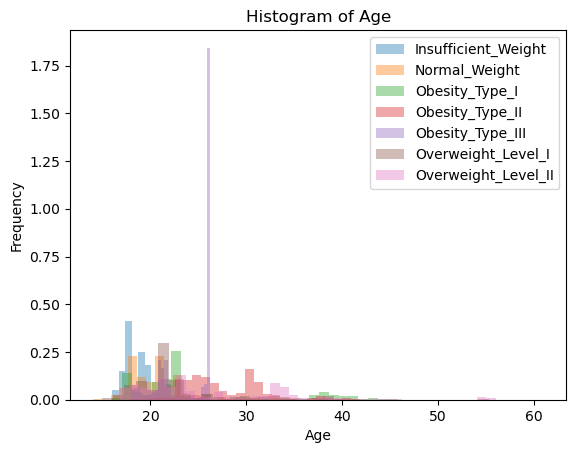

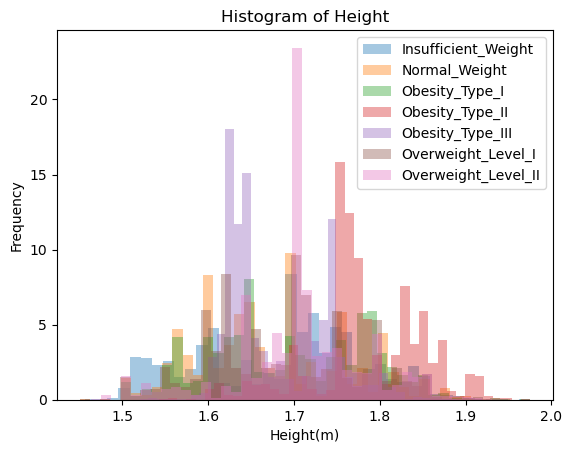

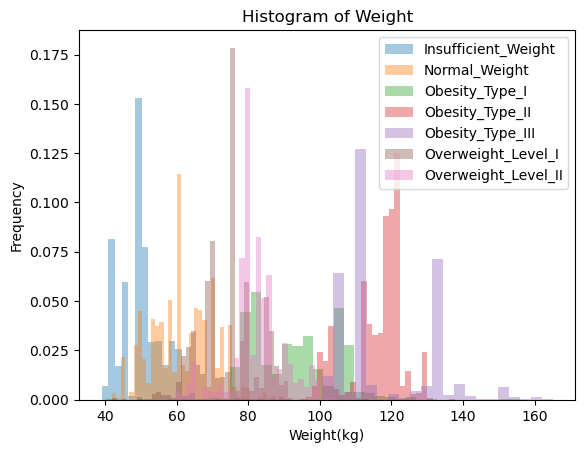

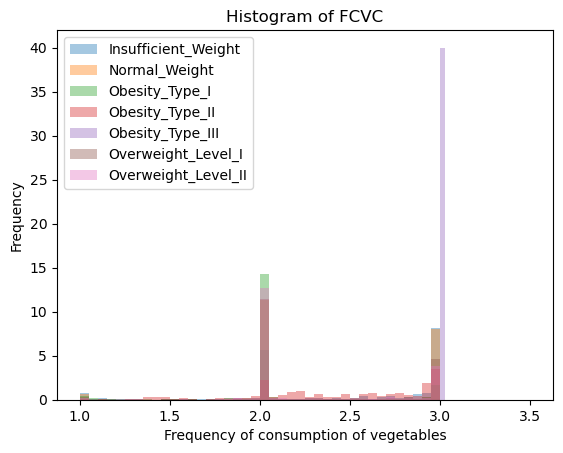

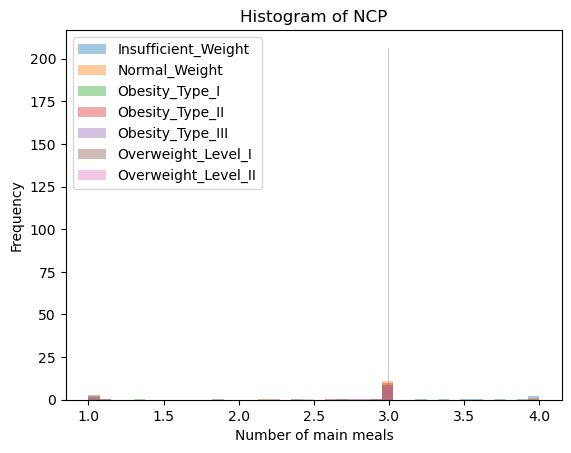

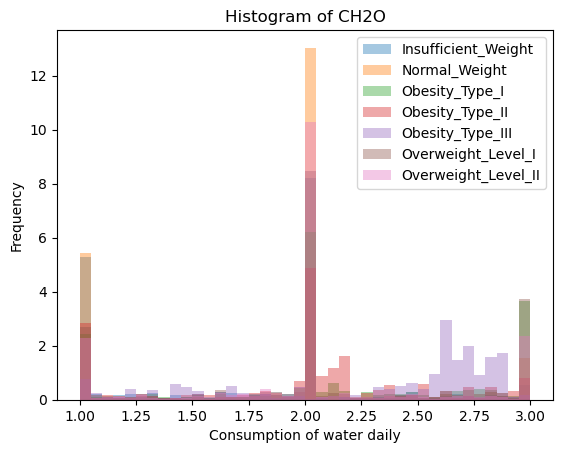

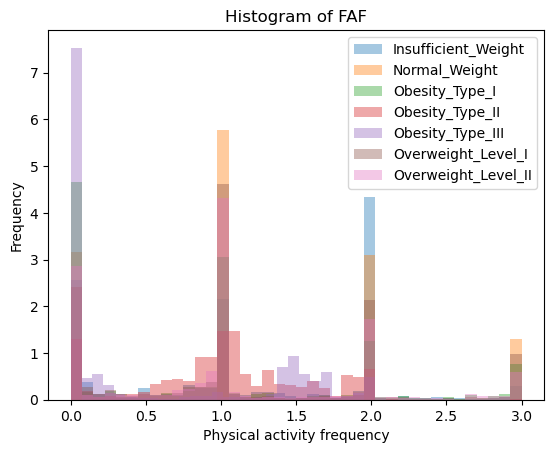

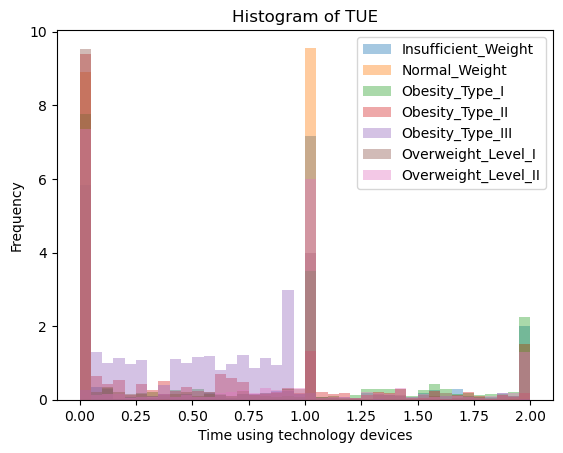

In [11]:
for feat in numeric_cols:
    ax = train_df.groupby("NObeyesdad")[feat].plot.hist(bins=40, alpha=0.4, legend=True, density=True)
    plt.xlabel(data_description[feat])
    plt.title("Histogram of " + feat)
    plt.show()

In [39]:
def alt_group_chart(data, group_on, var, data_description, columns=3):
    
    """
    Creates a faceted group histogram chart using Altair.

    This function takes a DataFrame and creates a histogram for a specified variable. 
    The histograms are then faceted into multiple charts based on the categories 
    of a specified grouping variable. Each individual chart is displayed with 
    independent x and y scales.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the data to be visualized.
    - group_on (str): The name of the column in 'data' to group the histograms by. 
                      Each unique value in this column will create a new facet in the chart.
    - var (str): The name of the column in 'data' to be used for the histogram values.
    - data_description (dict): A dictionary providing descriptions for the columns. 
                              It should contain a key with the same name as 'var' providing a 
                              descriptive title for the histogram's x-axis.
    - columns (int, optional): The number of columns to display in the faceted chart. 
                               Defaults to 3.

    Returns:
    - altair.vegalite.v4.api.FacetChart: An Altair FacetChart object that can be displayed 
                                         in a Jupyter Notebook or rendered as an image.

    Example:
    >>> df = pd.DataFrame({'category': ['A', 'B', 'A', 'C'], 
                           'value': [10, 15, 20, 25]})
    >>> chart = alt_group_chart(df, 'category', 'value', 
                                {'value': 'Value Distribution'})
    >>> chart.display()
    """
    #Base histogram chart for visualization
    base_chart = alt.Chart(data).mark_bar().encode(
        alt.X(var, title=data_description[var], bin=alt.Bin(maxbins=30)),
        y = 'count()'
    ).properties(width=150, height=100)

    # Facet based on the categories of y
    facet_chart = base_chart.facet(
        group_on, columns=columns
    ).resolve_scale(
        x = 'independent',
        y = 'independent'
).properties(
        title=f"Distribution of {var} over obesity level"
    )
    return facet_chart

In [40]:
all_charts = None

for feat in numeric_cols:
    chart = alt_group_chart(train_df, 'NObeyesdad', feat, data_description)
    
    if all_charts is None:
        all_charts = chart
    else:
        all_charts = alt.vconcat(all_charts, chart)  # Vertically concatenate charts

all_charts

alt.VConcatChart(...)

In [13]:
train_df.nunique()

id                                20758
Gender                                2
Age                                1703
Height                             1833
Weight                             1979
family_history_with_overweight        2
FAVC                                  2
FCVC                                934
NCP                                 689
CAEC                                  4
SMOKE                                 2
CH2O                               1506
SCC                                   2
FAF                                1360
TUE                                1297
CALC                                  3
MTRANS                                5
NObeyesdad                            7
dtype: int64